# Notebook 6 of 6 - Final Model Analysis
**Author:** Alexandru Mihalache 

**Date:** November 2022

In [1]:
import pandas as pd
import numpy as np

#Plotting liibs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
# fuzz is used to compare TWO strings
from fuzzywuzzy import fuzz
# process is used to compare a string to MULTIPLE other strings
from fuzzywuzzy import process
import load_data
import pre_processing_utils as ppu
from itertools import cycle

# ML libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, label_binarize, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

#Model scoring 
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, confusion_matrix, confusion_matrix, plot_confusion_matrix, mean_squared_error, r2_score, roc_curve, auc

/Users/alexmihalache/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**Aim of this notebook:** Validate how well the models perform in answering the initial question behind this project, which was to see if I could arive at a model or set of models that can with reasonable accuracy predict how a player may perform in a new team, to be used as part of the player scouting process.

In [2]:
# load data
xt, xt_test, vaep, vaep_test, games, games_test, players, players_test, target_players = load_data.load_data()

In [28]:
modeling_train_df = vaep.copy()
modeling_test_df = vaep_test.copy()
modeling_xt_train_df = xt.copy()
modeling_xt_test_df = xt_test.copy()

Find a player to run the models on.

In [20]:
target_players.head(5)

,player_id,player_name,minutes_played
0,24239,Jemma Elizabeth Purfield,2016
1,15579,Inessa Kaagman,2015
2,5076,Emily Louise van Egmond,1940
3,5074,Shelina Laura Zadorsky,1930
4,31534,Ella Toone,1887


Will take a player with a high number of minutes played

In [49]:
player_id = 15579 # to be used for predictions
post_transfer_team = 965 # to be used for model training
pre_transfer_team = 967 # may be used for comparisons

## Run models against player dataset

**Approach:**

- Use the player's pre-transfer data, to feed it to the model to make predictions on the 4 areas we are targeting. 
- Then taking the player's post transfer data, compare how close the model predictions got to, in modeling stylistic elements (next action and end zone) and value add contribution (VAEP and xT)

In [33]:
from tempfile import mkdtemp
cachedir = mkdtemp()

First will run all 4 models and train them on the chosen player's new team data.

In [ ]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',post_transfer_team, modeling_train_df, modeling_test_df, 'vaep_value')

numeric_features_vaep, categorical_features_vaep, drop_features_vaep = ppu.set_ct_mode('team-vaep')

# define column transformed for pipeline
ct_vaep = make_column_transformer(
    (StandardScaler(), numeric_features_vaep),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features_vaep),
    # ('passthrough', passthrough_features),
    ('drop', drop_features_vaep))


pipe_vaep = make_pipeline(ct_vaep, xgb.XGBRegressor(max_depth=8, gamma=0.01, reg_alpha=1.1, eta=0.1))
pipe_vaep.fit(X_train, y_train)


In [ ]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',post_transfer_team, modeling_xt_train_df, modeling_xt_test_df, 'xT_value')


numeric_features_xt, categorical_features_xt, drop_features_xt = ppu.set_ct_mode('team-xt')

# pipeline column transformer
ct_xt = make_column_transformer(
    (StandardScaler(), numeric_features_xt),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features_xt),
    # ('passthrough', passthrough_features),
    ('drop', drop_features_xt))

pipe_xt = make_pipeline(ct_xt, xgb.XGBRegressor(max_depth=5, reg_lambda=200))
pipe_xt.fit(X_train, y_train)

In [ ]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',post_transfer_team, modeling_train_df, modeling_test_df, 'type_name_encoded')

numeric_features_action, categorical_features_action, drop_features_action = ppu.set_ct_mode('team-action')

ct_action = make_column_transformer(
    (StandardScaler(), numeric_features_action),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features_action),
    # ('passthrough', passthrough_features),
    ('drop', drop_features_action))


pipe_action = make_pipeline(ct_action, xgb.XGBClassifier(max_depth=3, eta=0.3, gamma=0.01))
pipe_action.fit(X_train, y_train)

In [ ]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',post_transfer_team, modeling_train_df, modeling_test_df, 'end_pitch_zone')

numeric_features_end, categorical_features_end, drop_features_end = ppu.set_ct_mode('team-end')

ct_end = make_column_transformer(
    (StandardScaler(), numeric_features_end),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features_end),
    # ('passthrough', passthrough_features),
    ('drop', drop_features_end))



pipe_end = make_pipeline(ct_end, xgb.XGBClassifier(max_depth=3, eta=0.3, gamma=0.01))
pipe_end.fit(X_train, y_train)

Filter the player's pre-transfer data to feed into the model for prediction.

In [56]:
# create the dataset to run the prediction on

player_data_pre_transfer = modeling_train_df[modeling_train_df['player_id']==player_id]
player_data_pre_transfer_xt = modeling_xt_train_df[modeling_xt_train_df['player_id']==player_id]

In [57]:
# predict the 4 target variables
vaep_pred = pipe_vaep.predict(player_data_pre_transfer)
xt_pred = pipe_xt.predict(player_data_pre_transfer_xt)
action_pred = pipe_action.predict(player_data_pre_transfer)
end_pred = pipe_end.predict(player_data_pre_transfer)

# add prediction into player's data sets
player_data_pre_transfer['vaep_pred'] = vaep_pred
player_data_pre_transfer_xt['xt_pred'] = xt_pred
player_data_pre_transfer['action_pred'] = action_pred
player_data_pre_transfer['end_pred'] = end_pred

**Visualise results**

- Here I will compare reality with the predicted values 
- I dont expect an identical match, however we want to see how close our model can get in this iteration 
- Further I would like to see how we might be able to interpret the model results in a scouting process

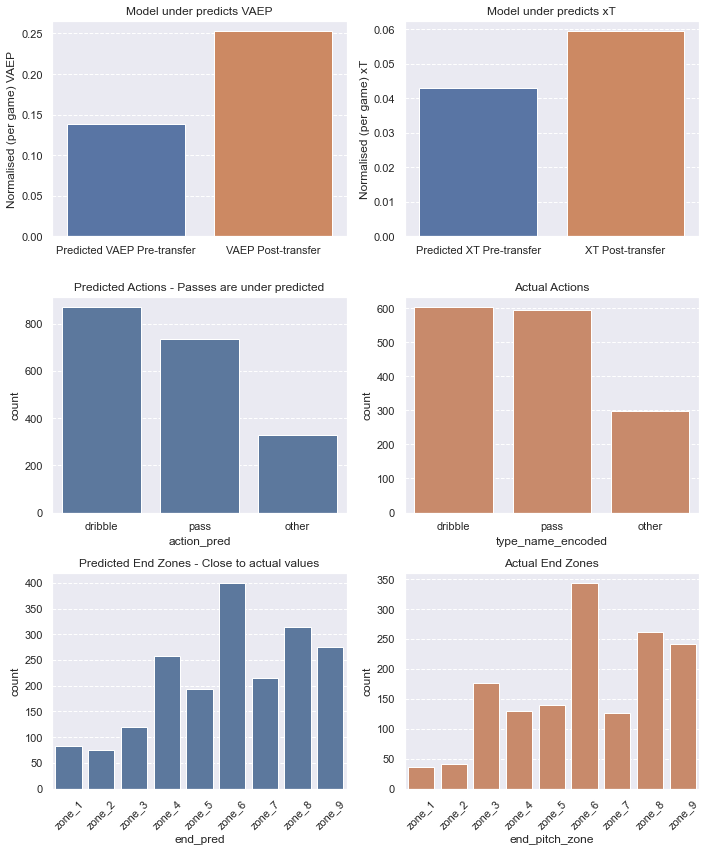

In [132]:
plt.subplots(3, 2, figsize=(10,12))
sns.set_theme()
plt.subplot(3,2,1)
sns.barplot(['Predicted VAEP Pre-transfer','VAEP Post-transfer'],[(player_data_pre_transfer['vaep_pred'].sum()/30), vaep_test[vaep_test['player_id'] == player_id]['vaep_value'].sum()/22])
plt.ylabel('Normalised (per game) VAEP')
plt.title('Model under predicts VAEP')
plt.grid(axis='y', linestyle = '--')

plt.subplot(3,2,2)
sns.barplot(['Predicted XT Pre-transfer','XT Post-transfer'],[player_data_pre_transfer_xt['xt_pred'].sum()/30, xt_test[xt_test['player_id'] == player_id]['xT_value'].sum()/22])
plt.ylabel('Normalised (per game) xT')
plt.title('Model under predicts xT')
plt.grid(axis='y', linestyle = '--')

plt.subplot(3,2,3)
sns.countplot(player_data_pre_transfer['action_pred'],color='#5176a8')
plt.title('Predicted Actions - Passes are under predicted')
plt.grid(axis='y', linestyle = '--')

plt.subplot(3,2,4)
sns.countplot(vaep_test[vaep_test['player_id'] == player_id]['type_name_encoded'],color='#d8855b')
plt.title('Actual Actions')
plt.grid(axis='y', linestyle = '--')

plt.subplot(3,2,5)
sns.countplot(player_data_pre_transfer['end_pred'].sort_values(), color='#5176a8')
plt.grid(axis='y', linestyle = '--')
plt.title('Predicted End Zones - Close to actual values')
plt.xticks(rotation=45)

plt.subplot(3,2,6)
sns.countplot(vaep_test[vaep_test['player_id'] == player_id]['end_pitch_zone'].sort_values(), color='#d8855b')
plt.xticks(rotation=45)
plt.title('Actual End Zones')
plt.grid(axis='y', linestyle = '--')

plt.tight_layout()
plt.show()

**Observations on model performance when applied to the project question**

- From this we can see that end_pitch_zone and xT perform the best, but can still be improved upon
- Next action and VAEP will require further research to be improved and in their current state I dont think they provide reliable insights
- For xT we're nearly at 70% of the true value - this means we couldnt do a comparison with existing players to see if there is an opportunity to replace one player for another through using this method. 
- For end zone - this predicts a very close match in terms of the shape of the distribution - but at a different scale - perhaps this is caused by the number of records between the prediction set and the actual data. However there could also be a concern here that the predictions are more an indication of the class imbalances in the training data rather than the a sign of accuracy. 

Overall the models got close to predicting the true values, and we have identified a number of areas to iterate on the models on to improve their performance. 
- balance all classification input data
- binarise zone data, to focus on a specific zone of group of zones vs the rest
- run further hyper parameter optimisation 
- optimise each model for each team, rather than a general optimisation - this is currently a big limitation of the current models, which is that they were optimised for a specific team but then they are applied to another, which may not give the best outcome

Another limitation of the models is that I haven't accounted for major play style changes between seasons, for examples teams change managers, or have new tactical ideas they want to implement which have not been reflected in our planning. So this would be another area to improve on in a future iteration.